In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   252M      0  0:00:03  0:00:03 --:--:--  252M


In [3]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf      PetImages        sample_data
 kagglecatsanddogs_5340.zip  'readme[1].txt'


In [4]:
!ls PetImages/

Cat  Dog


Filter out corrupted images:
When working with lots of real-world image data, corrupted images are a common occurence. Let's filter out badly-encoded images that do not feature the string "JFIF" in their header . A JFIF file is a bitmap graphic that uses JPEG compression. It is saved using a variation of the common .JPEG file format

In [5]:
import os

num_skipped = 0
img_opened = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)   #PetImages//Cat  
    for fname in os.listdir(folder_path):                  
        fpath = os.path.join(folder_path, fname)           #PetImages//Cat//filename
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
            img_opened+=1
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)
print(f"Total_images images {img_opened} ")


Deleted 1590 images
Total_images images 25002 


Generate a Dataset ⏭
image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories class_a and class_b, together with labels 0 and 1 (0 corresponding to class_a and 1 corresponding to class_b).

In [6]:
image_size = (180, 180)
batch_size = 128

train_ds = tf.keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    seed=1337,
    subset = "training",
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.


In [7]:
image_size = (180, 180)
batch_size = 128

val_ds = tf.keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    seed=1337,
    subset = "validation",
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


Visualization of data

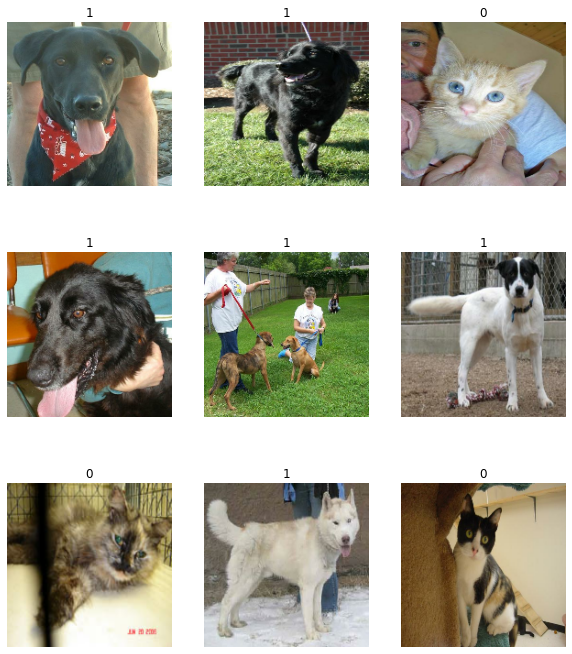

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

Data Augumentation ▶
Data Augumentaion helps your dataset to be more generalise . And it also increases the number images by simple type of transformation like rotation , flip , crop etc . This transformed images looks same for us but for computer it is completly new images . Data Augmentation also help in reducing overfitting . 

In [9]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

Lets Plot this variation

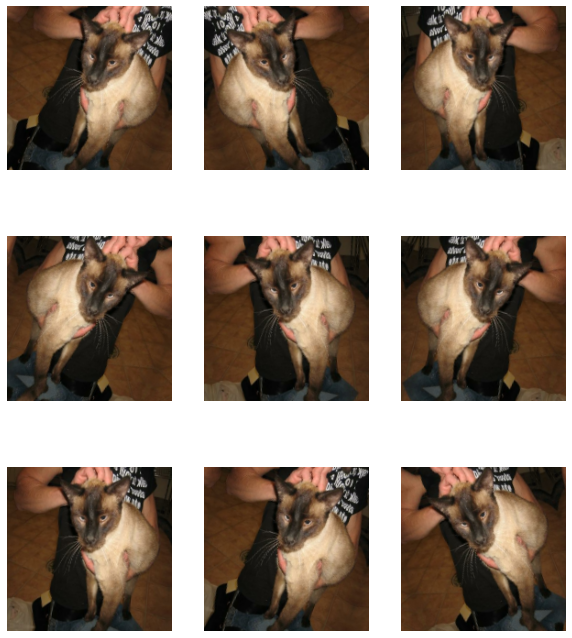

In [10]:
plt.figure(figsize=(10, 12))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Standardizing the data ▶ Why to standardized the data?
Standardization means rescale the data to have mean 0 and standard deviation 1 .
And in Normalization we resacle the data between [0,1] . 
We standardized the data so each feature comes to same scale ex - if we have a dataset having feature hight measure in cm and weight measure in kg then they have differnet scales and it will create difficulty in updating weights some weights will updated quicklly and some remain same . Standardization makes all variables contribute equally . 


In [11]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

What does input layer do:
basically it takes the data as Input for further presprocessing . 
It decide the size of what the weights are going to be look like . the weight initialization takes place randomly untill we didn't decide.

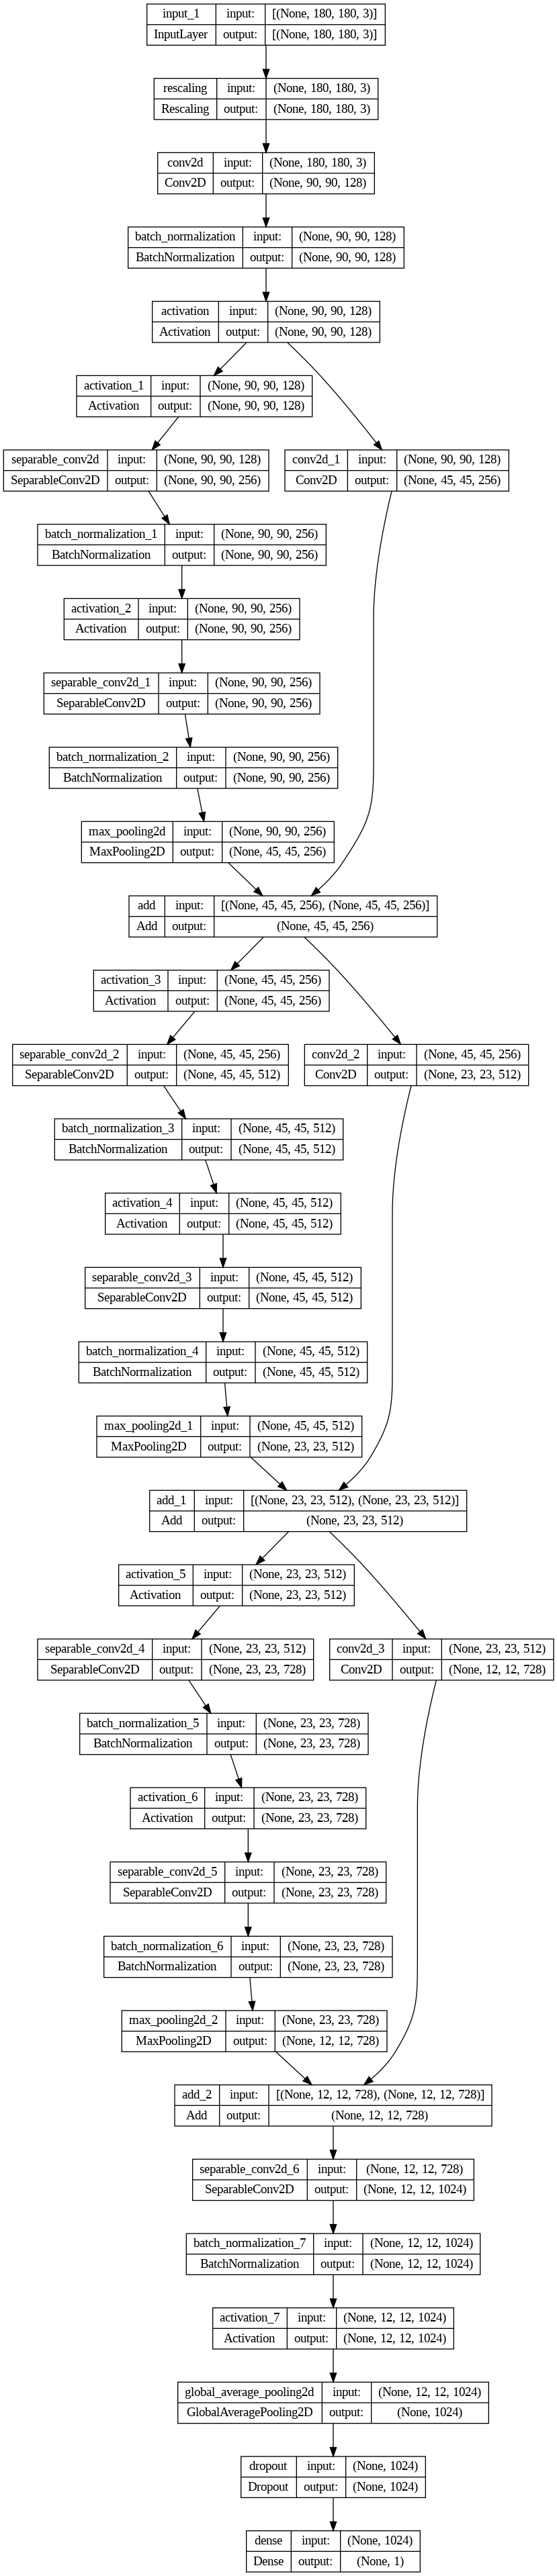

In [12]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)



In [ ]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
147/147 [==============================] - 348s 2s/step - loss: 0.6393 - accuracy: 0.6516 - val_loss: 0.8878 - val_accuracy: 0.4957
Epoch 2/25
147/147 [==============================] - 325s 2s/step - loss: 0.4898 - accuracy: 0.7635 - val_loss: 1.4419 - val_accuracy: 0.4957
Epoch 3/25
147/147 [==============================] - 325s 2s/step - loss: 0.3813 - accuracy: 0.8309 - val_loss: 1.5597 - val_accuracy: 0.4957
Epoch 4/25
147/147 [==============================] - 323s 2s/step - loss: 0.3190 - accuracy: 0.8625 - val_loss: 0.8739 - val_accuracy: 0.5803
Epoch 5/25
147/147 [==============================] - 327s 2s/step - loss: 0.2678 - accuracy: 0.8890 - val_loss: 0.2936 - val_accuracy: 0.8738
Epoch 6/25
147/147 [==============================] - 325s 2s/step - loss: 0.2256 - accuracy: 0.9063 - val_loss: 0.4377 - val_accuracy: 0.8358
Epoch 7/25
147/147 [==============================] - 325s 2s/step - loss: 0.1987 - accuracy: 0.9192 - val_loss: 0.2626 - val_accuracy: 0.8877

In [ ]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")